In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
pd.options.display.float_format = '{:.5f}'.format

# 데이터 불러오기

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
car_2020 = pd.read_csv('data/car_2020.csv',encoding='cp949')
age = pd.read_csv('data/age_gender_info.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
train.head()

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수
0,C2483,900,아파트,경상북도,국민임대,39.72000,134,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
1,C2483,900,아파트,경상북도,국민임대,39.72000,15,38.00000,A,15667000,103680,0.00000,3.00000,1425.00000,1015.00000
2,C2483,900,아파트,경상북도,국민임대,51.93000,385,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
3,C2483,900,아파트,경상북도,국민임대,51.93000,15,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000
4,C2483,900,아파트,경상북도,국민임대,51.93000,41,38.00000,A,27304000,184330,0.00000,3.00000,1425.00000,1015.00000


In [4]:
a = pd.qcut(train['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
train.insert(14,'단지규모',a)

In [5]:
train['총세대수'] = np.log(train['총세대수'])

car_2020 = car_2020.drop(['시군구(1)'], axis=1)
car_2020.columns = ['지역','월','항목','분류','자동차수']
car_2020['월'] = pd.to_datetime(car_2020['월']).dt.month
car_2020.head()

In [6]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    211
도보 10분거리 내 버스정류장 수                4
단지내주차면수                           0
단지규모                              0
등록차량수                             0
dtype: int64

In [7]:
test.loc[test.단지코드.isin(['C2411']) & test.자격유형.isnull(), '자격유형'] = 'A'
test.loc[test.단지코드.isin(['C2253']) & test.자격유형.isnull(), '자격유형'] = 'C'

train.loc[train.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'
test.loc[test.자격유형.isin(['H', 'B', 'E', 'G']), '자격유형'] = '국민임대/장기전세_공급대상'

train.loc[train.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'
test.loc[test.자격유형.isin(['C', 'I', 'F']), '자격유형'] = '영구임대_공급대상'

train.loc[train.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'
test.loc[test.자격유형.isin(['J', 'L', 'K', 'N', 'M', 'O']), '자격유형'] = '행복주택_공급대상'

pd.concat([train.자격유형.value_counts(),
           test.자격유형.value_counts()], axis=1)

,자격유형,자격유형
A,1801,573
D,569,180
국민임대/장기전세_공급대상,222,103
행복주택_공급대상,213,124
영구임대_공급대상,147,42


In [8]:
train_copy = train.copy()
train_copy = pd.get_dummies(train_copy,columns=['자격유형'])
del train_copy['등록차량수']
train_copy['등록차량수'] = train['등록차량수']
train = train_copy

In [9]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


# 컬럼명 바꿔주기

In [10]:
train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모', 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택', '등록차량수'
]

In [11]:
train.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,등록차량수
0,C2483,6.80239,아파트,경상북도,국민임대,39.72000,134,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
1,C2483,6.80239,아파트,경상북도,국민임대,39.72000,15,38.00000,15667000,103680,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000
2,C2483,6.80239,아파트,경상북도,국민임대,51.93000,385,38.00000,27304000,184330,0.00000,3.00000,1425.00000,2,1,0,0,0,0,1015.00000


In [12]:
train.shape

(2952, 20)

# 지하철 Y or N로 변경

In [13]:
train['지하철'] = train['지하철'].fillna(0)
train['지하철'] = np.where(train['지하철'] == 0, 0, 1)

# 결측치 처리

In [14]:
train.loc[train.임대보증금=='-', '임대보증금'] = np.nan
train.loc[train.임대료=='-', '임대료'] = np.nan
train['임대보증금'] = train['임대보증금'].astype(float)
train['임대료'] = train['임대료'].astype(float)
train['임대보증금'] = train['임대보증금'].fillna(0)
train['임대료'] = train['임대료'].fillna(0)

In [15]:
train['버스'] = train['버스'].fillna(train['버스'].mean())

In [16]:
train.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
등록차량수        0
dtype: int64

# 임대건물구분 : 아파트->상가 / 전용면적별세대수 : x->1

In [17]:
idx = train[(train['임대건물구분']=='아파트') & (train['D']=='D')]['전용면적별세대수'].index
train.loc[idx, '전용면적별세대수'] = 1
train.loc[idx, '임대건물구분'] = '상가'

In [18]:
# 원핫 인코딩
#train = pd.get_dummies(data = train, columns = ['지하철'])

# 지역명 숫자로 매핑

In [19]:
local_map = {}
for i, loc in enumerate(train['지역'].unique()):
    local_map[loc] = i
    
train['지역'] = train['지역'].map(local_map)

# 전용면적을 반올림

In [20]:
train['전용면적'] = np.round(train['전용면적'], 0) 
# train['전용면적'] = train['전용면적']//5*5

# 전용면적 상/하한 적용

In [21]:
idx = train[train['전용면적']>100].index
train.loc[idx, '전용면적'] = 100

idx = train[train['전용면적']<15].index
train.loc[idx, '전용면적'] = 15

In [22]:
a = pd.qcut(train['전용면적'], 3, labels=[1,2,3])
train.insert(loc=19, column='전용면적규모', value=a) 

In [23]:
train[train['전용면적규모'] == 1].shape[0], train[train['전용면적규모'] == 2].shape[0], train[train['전용면적규모'] == 3].shape[0]

(1227, 910, 815)

In [24]:
train.sample(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,...,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택,전용면적규모,등록차량수
745,C2109,6.20456,상가,1,임대상가,32.00000,1,2.00000,0.00000,0.00000,...,4.00000,117.00000,1,0,1,0,0,0,1,60.00000
193,C1616,7.31788,상가,2,임대상가,55.00000,1,1.00000,0.00000,0.00000,...,2.00000,407.00000,3,0,1,0,0,0,3,98.00000
1579,C1375,6.62936,아파트,1,국민임대,47.00000,63,21.00000,22471000.00000,137310.00000,...,12.00000,761.00000,2,1,0,0,0,0,2,754.00000


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   단지코드       2952 non-null   object  
 1   총세대수       2952 non-null   float64 
 2   임대건물구분     2952 non-null   object  
 3   지역         2952 non-null   int64   
 4   공급유형       2952 non-null   object  
 5   전용면적       2952 non-null   float64 
 6   전용면적별세대수   2952 non-null   int64   
 7   공가수        2952 non-null   float64 
 8   임대보증금      2952 non-null   float64 
 9   임대료        2952 non-null   float64 
 10  지하철        2952 non-null   int32   
 11  버스         2952 non-null   float64 
 12  단지내주차면수    2952 non-null   float64 
 13  단지규모       2952 non-null   category
 14  A          2952 non-null   uint8   
 15  D          2952 non-null   uint8   
 16  국민임대/장기전세  2952 non-null   uint8   
 17  영구임대       2952 non-null   uint8   
 18  행복주택       2952 non-null   uint8   
 19  전용면적규모     2952 non-null   

# test 불러오기

In [26]:
a = pd.qcut(test['총세대수'],3,labels=[1,2,3]) # 소단지,중단지,대단지
test.insert(14,'단지규모',a)

In [27]:
test_copy = test.copy()
test_copy = pd.get_dummies(test_copy,columns=['자격유형'])
test = test_copy

In [28]:
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,단지규모,자격유형_A,자격유형_D,자격유형_국민임대/장기전세_공급대상,자격유형_영구임대_공급대상,자격유형_행복주택_공급대상
0,C1072,754,아파트,경기도,국민임대,39.79000,116,14.00000,22830000,189840,0.00000,2.00000,683.00000,2,0,0,1,0,0
1,C1072,754,아파트,경기도,국민임대,46.81000,30,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,1,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.90000,112,14.00000,36048000,249930,0.00000,2.00000,683.00000,2,0,0,1,0,0


In [29]:
test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '단지규모' , 'A', 'D', '국민임대/장기전세', '영구임대', '행복주택'
]

In [30]:
test.isnull().sum()

단지코드           0
총세대수           0
임대건물구분         0
지역             0
공급유형           0
전용면적           0
전용면적별세대수       0
공가수            0
임대보증금        180
임대료          180
지하철           42
버스             0
단지내주차면수        0
단지규모           0
A              0
D              0
국민임대/장기전세      0
영구임대           0
행복주택           0
dtype: int64

In [31]:
test.loc[test.임대보증금=='-', '임대보증금'] = np.nan
test.loc[test.임대료=='-', '임대료'] = np.nan
test['임대보증금'] = test['임대보증금'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)
test['임대보증금'] = test['임대보증금'].astype(float)
test['임대료'] = test['임대료'].astype(float)

In [32]:
test['지하철'].value_counts()

0.00000    881
1.00000     64
2.00000     35
Name: 지하철, dtype: int64

In [33]:
test['지하철'] = test['지하철'].fillna(0)
test['지하철'] = np.where(test['지하철'] == 0, 0, 1)

In [34]:
test.head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,임대보증금,임대료,지하철,버스,단지내주차면수,단지규모,A,D,국민임대/장기전세,영구임대,행복주택
0,C1072,754,아파트,경기도,국민임대,39.79000,116,14.00000,22830000.00000,189840.00000,0,2.00000,683.00000,2,0,0,1,0,0
1,C1072,754,아파트,경기도,국민임대,46.81000,30,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,1,0,0,0,0
2,C1072,754,아파트,경기도,국민임대,46.90000,112,14.00000,36048000.00000,249930.00000,0,2.00000,683.00000,2,0,0,1,0,0


In [35]:
local_map = {}
for i, loc in enumerate(test['지역'].unique()):
    local_map[loc] = i
    
test['지역'] = test['지역'].map(local_map)

In [36]:
test['전용면적'] = np.round(test['전용면적'], 0) 
# test['전용면적'] = test['전용면적']//5*5

idx = test[test['전용면적']>100].index
test.loc[idx, '전용면적'] = 100

idx = test[test['전용면적']<15].index
test.loc[idx, '전용면적'] = 15

a = pd.qcut(test['전용면적'], 3, labels=[1,2,3])
test.insert(loc=19, column='전용면적규모', value=a) 

In [37]:
test.isnull().sum()

단지코드         0
총세대수         0
임대건물구분       0
지역           0
공급유형         0
전용면적         0
전용면적별세대수     0
공가수          0
임대보증금        0
임대료          0
지하철          0
버스           0
단지내주차면수      0
단지규모         0
A            0
D            0
국민임대/장기전세    0
영구임대         0
행복주택         0
전용면적규모       0
dtype: int64

In [38]:
# columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모', 
#            'A', 'D', '국민임대/장기전세', '영구임대', '행복주택']
# columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모']
columns = ['총세대수', '지역', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '단지규모', '전용면적규모']
target = '등록차량수'
area_columns = []
for area in train['전용면적'].unique():
    area_columns.append(f'면적_{area}')

In [39]:
new_train = pd.DataFrame()
new_test = pd.DataFrame()

In [40]:
new_train['임대보증금'] = 0
new_train['임대료'] = 0
new_test['임대보증금'] = 0
new_test['임대료'] = 0

## 수정한 코드

In [41]:
# Train Dataframe Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료
for i, code in tqdm(enumerate(train['단지코드'].unique())):
    temp = train[train['단지코드']==code]
    temp.index = range(temp.shape[0]) # index 재설정
    for col in columns:
        new_train.loc[i, col] = temp.loc[0, col] # Fixed Data
    
    deposit_cost = []
    rental_cost = []

    for col in area_columns:
        area = float(col.split('_')[-1]) # 면적의 숫자를 float형으로 저장
        # '면적_10' 등의 열을 만들고 - 같은 전용면적들 끼리 전용면적별세대수의 합을 Value로 Cell에 입력
#         new_train.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
    
    new_train.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    # print(type(deposit_cost[0]))
    new_train.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_train.loc[i, '임대료'] = int(np.mean(rental_cost))

# Test DataFrame Set
# 미사용 열s - 임대건물구분, 공급유형, 자격유형 임대보증금, 임대료, 등록차량수
for i, code in tqdm(enumerate(test['단지코드'].unique())):
    temp = test[test['단지코드']==code]
    temp.index = range(temp.shape[0])
    for col in columns:
        new_test.loc[i, col] = temp.loc[0, col]

    deposit_cost = []
    rental_cost = []
    
    for col in area_columns:
        area = float(col.split('_')[-1])
#         new_test.loc[i, col] = temp[temp['전용면적']==area]['전용면적별세대수'].sum()
        
        try:
          deposit_cost.append(temp[temp['전용면적']==area]['임대보증금'][0])
          rental_cost.append(temp[temp['전용면적']==area]['임대료'][0])
        except KeyError as e:
          continue
          
    new_test.loc[i, '임대보증금'] = int(np.mean(deposit_cost))
    new_test.loc[i, '임대료'] = int(np.mean(rental_cost))


# 추가해볼 것 임대보증금 , 임대료 Column 만들고 평균

423it [00:15, 26.57it/s]
150it [00:05, 26.27it/s]


In [68]:
new_train

,임대보증금,임대료,총세대수,지역,전용면적별세대수,공가수,지하철,버스,단지내주차면수,단지규모,전용면적규모,등록차량수
0,15667000.00000,103680.00000,6.80239,0.00000,134.00000,38.00000,0.00000,3.00000,1425.00000,2.00000,2.00000,1015.00000
1,9216000.00000,82940.00000,6.30079,1.00000,276.00000,17.00000,0.00000,3.00000,624.00000,1.00000,1.00000,205.00000
2,15620000.00000,127350.00000,7.10332,2.00000,288.00000,13.00000,1.00000,1.00000,1285.00000,3.00000,1.00000,1064.00000
3,15607000.00000,130070.00000,6.62672,3.00000,120.00000,6.00000,1.00000,3.00000,734.00000,2.00000,2.00000,730.00000
4,12015000.00000,102130.00000,6.54535,4.00000,228.00000,14.00000,0.00000,2.00000,645.00000,2.00000,1.00000,553.00000
...,...,...,...,...,...,...,...,...,...,...,...,...
418,16800000.00000,71400.00000,4.49981,9.00000,12.00000,7.00000,0.00000,3.00000,66.00000,1.00000,1.00000,57.00000
419,10000000.00000,117000.00000,6.19848,5.00000,132.00000,24.00000,0.00000,1.00000,521.00000,1.00000,1.00000,246.00000
420,18000000.00000,87000.00000,3.68888,8.00000,20.00000,7.00000,1.00000,2.00000,25.00000,1.00000,1.00000,19.00000
421,10346000.00000,107530.00000,4.49981,11.00000,90.00000,12.00000,0.00000,1.00000,30.00000,1.00000,1.00000,16.00000


In [153]:
data = new_train[['단지내주차면수', '총세대수', '단지규모']]

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(data)
a = pca.transform(data)


pca_columns=['x','y']

b = pd.DataFrame(a,columns=pca_columns)
b

,x,y
0,832.25465,1.15028
1,31.25403,0.74922
2,692.25673,-0.11696
3,141.25569,-0.05939
4,52.25575,-0.18324
...,...,...
418,-526.74715,0.67492
419,-71.74591,0.61032
420,-567.74805,1.03860
421,-562.74708,0.60692


In [154]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(data)

KMeans(n_clusters=3)

In [155]:
b['cluster_label'] = kmeans.labels_

In [160]:
b

,x,y,cluster_label
0,832.25465,1.15028,1
1,31.25403,0.74922,0
2,692.25673,-0.11696,1
3,141.25569,-0.05939,0
4,52.25575,-0.18324,0
...,...,...,...
418,-526.74715,0.67492,2
419,-71.74591,0.61032,0
420,-567.74805,1.03860,2
421,-562.74708,0.60692,2


C:\Users\ui828\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


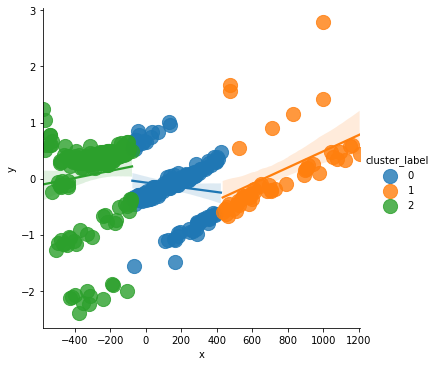

In [159]:
sns.lmplot('x','y',data=b, fit_reg = True,
          scatter_kws={"s":200},
          hue="cluster_label")

In [69]:
new_train_copy = new_train.copy()
new_test_copy = new_test.copy()

x_train = new_train_copy.iloc[:, :-1]
y_train = new_test_copy.iloc[:,-1]

x_test = x_new_test_copy

In [66]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 0 to 422
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   임대보증금     423 non-null    float64
 1   임대료       423 non-null    float64
 2   총세대수      423 non-null    float64
 3   지역        423 non-null    float64
 4   전용면적별세대수  423 non-null    float64
 5   공가수       423 non-null    float64
 6   지하철       423 non-null    float64
 7   버스        423 non-null    float64
 8   단지내주차면수   423 non-null    float64
 9   단지규모      423 non-null    float64
 10  전용면적규모    423 non-null    float64
dtypes: float64(11)
memory usage: 55.8 KB


In [71]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 423 entries, 0 to 422
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   임대보증금     423 non-null    float64
 1   임대료       423 non-null    float64
 2   총세대수      423 non-null    float64
 3   지역        423 non-null    float64
 4   전용면적별세대수  423 non-null    float64
 5   공가수       423 non-null    float64
 6   지하철       423 non-null    float64
 7   버스        423 non-null    float64
 8   단지내주차면수   423 non-null    float64
 9   단지규모      423 non-null    float64
 10  전용면적규모    423 non-null    float64
dtypes: float64(11)
memory usage: 55.8 KB


In [72]:
# x_train['임대보증금'] = x_train['임대보증금'].apply('float64')
# import math
# x_train['임대보증금'] = math.log(x_train['임대보증금'])
# x_train['임대보증금'] = x_train['임대보증금'].fillna(0)

C:\Users\pksmb\anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


TypeError: cannot convert the series to <class 'float'>

In [ ]:
import math
from sklearn import preprocessing
# 특정 변수에만 함수 적용
df['X_log'] = preprocessing.scale(np.log(df['X']+1)) # 로그
# df['X_sqrt'] = preprocessing.scale(np.sqrt(df['X']+1)) # 제곱근
# 데이터 프레임 전체에 함수 적용 (단, 숫자형 변수만 있어야 함)
# df_log = df.apply(lambda x: np.log(x+1))

In [64]:
forest = RandomForestRegressor(n_jobs=-1, random_state=42)
forest.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
pred = forest.predict(x_test)

In [ ]:
submission['num'] = pred

In [ ]:
submission

In [ ]:
# submission.to_csv('./신분OneHot.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
x = new_train.iloc[:, :-1]
y = new_train.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)
forest = RandomForestRegressor(random_state=0)
forest.fit(x_train, y_train)
pred = forest.predict(x_test)
mean_absolute_error(y_test, pred)

In [ ]:
# 단지코드 포함 | 신분 One-Hot 포함 : 132.36037735849055
# 단지코드 포함 | 신분 One-Hot 제외 : 131.0185849056604

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
new_train.columns

In [ ]:
fig, ax = plt.subplots(11, 3, figsize=(25, 35))

for i, feature in enumerate(new_train.columns):
    row = int( i // 3 )
    col = i % 3
    
    sns.set_theme(style='darkgrid', palette='cividis', font='gulim', font_scale=2)
    sns.regplot(data=new_train, x=feature, y='등록차량수', ax=ax[row][col], robust=True)

In [ ]:
for i, feature in enumerate(new_train.columns):
    print(f'{i} - {feature}')